In [65]:
from utils import *
import os

In [66]:
iemocap = pd.read_csv("iemocap.csv")
msp_podcast = pd.read_csv("msp-podcast.csv")
msp_improv = pd.read_csv("msp-improv.csv")
crema_d = pd.read_csv("crema-d.csv")

In [67]:
podcast_emotion = ['angry','sad','disgust','contempt', 'fear', 'neutral','surprise','happy']
improv_emotion = ["angry","sad","neutral","happy"]
iemocap_emotion = ["frustrated","angry","sad","disgust","fear","neutral","surprise","happy"] # Happy & Excited combine together
crema_emotion = ["angry","sad","disgust","fear","neutral","happy"]

In [68]:
# Combine happy and excited emotion
iemocap['happy'] = iemocap['happy'] + iemocap['excited']
iemocap = iemocap.drop(columns='excited')

### Get the dominant emotion and the drop rate

In [70]:
def get_dominant_emotion(corpus, all_emotions):
    # Create a new column for dominant emotion
    corpus['dominant_emotion'] = None
    
    # Iterate through each row of the dataframe
    for index, row in corpus.iterrows():
        # Get emotion scores for all emotions in the dataset
        emotion_scores = [row[emotion] for emotion in all_emotions if emotion in row]
        # Find the maximum score
        max_score = max(emotion_scores)
        
        # Find all emotions with the maximum score
        max_emotions = [emotion for emotion in all_emotions if emotion in row and row[emotion] == max_score]
        # If there's only one emotion with max score, it's the dominant one
        if len(max_emotions) == 1:
            corpus.at[index,'dominant_emotion'] = max_emotions[0]
        else:
            # If there's a tie, mark as 'ambiguous' or handle as needed
            corpus.at[index,'dominant_emotion'] = 'ambiguous'

    # Remove rows where dominant_emotion is NaN
    corpus = corpus.dropna(subset=['dominant_emotion'])
    return corpus

In [71]:
iemocap = get_dominant_emotion(iemocap,iemocap_emotion)
drop_rate_calculator(iemocap)

drop rate of Train set : 0.00%
drop rate of Development set : 0.00%
drop rate of Test set : 0.00%
Overall drop rate : 0.00%


In [72]:
msp_podcast = get_dominant_emotion(msp_podcast,podcast_emotion)
drop_rate_calculator(msp_podcast)

drop rate of Train set : 0.00%
drop rate of Development set : 0.00%
drop rate of Test set : 0.00%
Overall drop rate : 0.00%


In [74]:
msp_improv = get_dominant_emotion(msp_improv,improv_emotion)
drop_rate_calculator(msp_improv)

drop rate of Train set : 0.00%
drop rate of Development set : 0.00%
drop rate of Test set : 0.00%
Overall drop rate : 0.00%


In [73]:
crema_d = get_dominant_emotion(crema_d,crema_emotion)
drop_rate_calculator(crema_d)

drop rate of Train set : 0.00%
drop rate of Development set : 0.00%
drop rate of Test set : 0.00%
Overall drop rate : 0.00%


### Normalize the Activation & Valence
Crema-D no need, since it doesn't have dimensional emotion data 

In [75]:
print('='*10 + ' IEMOCAP '.center(12) + '='*10)
iemocap = Normalize_dimensional_emotion(iemocap)
print('='*10 + ' MSP-Podcast '.center(12) + '='*10)
msp_podcast = Normalize_dimensional_emotion(msp_podcast)
print('='*10 + ' MSP-Improv '.center(12) + '='*10)
msp_improv = Normalize_dimensional_emotion(msp_improv)

==========  IEMOCAP   ==========
Activation: Min 1.0 Max5.0
Valence: Min 1.0 Max5.0
========== MSP-Podcast ==========
Activation: Min 1.0 Max7.0
Valence: Min 1.0 Max7.0
========== MSP-Improv ==========
Activation: Min 1.0 Max5.0
Valence: Min 1.0 Max5.0


### Remove the ambiguous data

In [76]:
def ambiguous_segregation(corpus,file_name):
    ambiguous_data = corpus[corpus['dominant_emotion'] == 'ambiguous']
    ambiguous_data.to_csv(os.path.join('ambiguous',file_name))
    new_data = corpus[corpus['dominant_emotion'] != 'ambiguous']
    return new_data

In [79]:
iemocap = ambiguous_segregation(iemocap,'iemocap_ambiguous.csv')
msp_podcast = ambiguous_segregation(msp_podcast,'msp_podcast_ambiguous.csv')
msp_improv = ambiguous_segregation(msp_improv,'msp_improv_ambiguous.csv')
crema_d = ambiguous_segregation(crema_d,'crema_d_ambiguous.csv')

### Get the total Train set

In [86]:
def train_segregation(corpus,file_name):
    val_test_data = corpus[corpus['Split_Set'] != 'Train']
    val_test_data.to_csv(os.path.join('val&test',file_name))
    new_data = corpus[corpus['Split_Set'] == 'Train']
    return new_data

In [87]:
iemocap = train_segregation(iemocap,'iemocap_val&test.csv')
msp_podcast = train_segregation(msp_podcast,'msp_podcast_val&test.csv')
msp_improv = train_segregation(msp_improv,'msp_improv_val&test.csv')
# crema_d = train_segregation(crema_d,'crema_d_test.csv') #Only saved test_data

In [92]:
# Create a new dataframe with selected columns from each corpus
columns_to_keep = ['FileName', 'dominant_emotion', 'EmoAct', 'EmoVal', 'Gender']

# Create empty dataframes for each corpus with the required columns
iemocap_selected = iemocap[columns_to_keep].copy()
iemocap_selected['Corpus'] = 'IEMOCAP'

msp_podcast_selected = msp_podcast[columns_to_keep].copy()
msp_podcast_selected['Corpus'] = 'MSP-PODCAST'

msp_improv_selected = msp_improv[columns_to_keep].copy()
msp_improv_selected['Corpus'] = 'MSP-IMPROV'

# Combine all dataframes into one
combined_df = pd.concat([iemocap_selected, msp_podcast_selected, msp_improv_selected], ignore_index=True)

# Display the first few rows of the combined dataframe
combined_df.head()

,FileName,dominant_emotion,EmoAct,EmoVal,Gender,Corpus
0,Ses01F_script01_1_M026.wav,frustrated,0.583333,0.250,Male,IEMOCAP
1,Ses01F_impro04_M016.wav,neutral,0.333333,0.500,Male,IEMOCAP
2,Ses01F_script03_1_F010.wav,happy,0.625000,0.625,Female,IEMOCAP
3,Ses01F_script03_1_M038.wav,happy,0.375000,0.500,Male,IEMOCAP
4,Ses01F_script03_2_F029.wav,angry,0.625000,0.375,Female,IEMOCAP


In [94]:
Counter(combined_df['Gender'])

Counter({'Male': 35371, 'Female': 29647, 'Unknown': 12395})

In [96]:
total_emotion = ['frustrated','neutral','happy','angry','surprise','sad','fear','disgust','contempt']

In [11]:
shared_emotion = set()
not_shared_emotion = set()
for emo in iemocap_emotion:
    if emo in improv_emotion:
        shared_emotion.add(emo) 
    elif emo in podcast_emotion:
        shared_emotion.add(emo) 
    else:
        not_shared_emotion.add(emo)

print(shared_emotion)
print(not_shared_emotion)

"""
MSPPODCAST
{'neutral', 'fear', 'sad', 'disgust', 'surprise', 'happy', 'angry'}
{'contempt'}

IEMOCAP
{'neutral', 'fear', 'sad', 'disgust', 'surprise', 'happy', 'angry'}
{'frustrated', 'excited'}
"""
    

{'neutral', 'fear', 'sad', 'disgust', 'surprise', 'happy', 'angry'}
{'frustrated', 'excited'}


"\nMSPPODCAST\n{'neutral', 'fear', 'sad', 'disgust', 'surprise', 'happy', 'angry'}\n{'contempt'}\n\nIEMOCAP\n"

In [111]:
def get_main_plot(emotion_cols, df):
    # Create a single figure with appropriate size
    fig, ax = plt.subplots(figsize=(8, 5))
    #! larger graph can help
    
    # Plot all emotions in the plot
    for emotion in emotion_cols:
        mask = df['dominant_emotion'] == emotion
        ax.scatter(df.loc[mask, 'EmoVal'], 
                    df.loc[mask, 'EmoAct'],
                    label=emotion,
                    alpha=0.7)
    
    # Add circular grid
    center = (0.5, 0.5)
    radius = 0.5
    theta = np.linspace(0, 2*np.pi, 100)
    
    # Draw concentric circles
    for r in np.linspace(0, radius, 6):
        x = center[0] + r * np.cos(theta)
        y = center[1] + r * np.sin(theta)
        ax.plot(x, y, 'gray', alpha=0.3)
    
    # Draw radial lines
    for angle in np.linspace(0, 2*np.pi, 12, endpoint=False):
        x = [center[0], center[0] + radius * np.cos(angle)]
        y = [center[1], center[1] + radius * np.sin(angle)]
        ax.plot(x, y, 'gray', alpha=0.3)
    
    # Set titles and labels
    ax.set_title('Emotion Distribution')
    ax.set_xlabel('Emotional Valence (EmoVal)')
    ax.set_ylabel('Emotional Activation (EmoAct)')
    ax.legend()
    ax.axis('equal')
    ax.set_xlim(center[0] - radius - 0.1, center[0] + radius + 0.1)
    ax.set_ylim(center[1] - radius - 0.1, center[1] + radius + 0.1)
    
    plt.tight_layout()
    plt.show()

def get_full_plot(emotion_cols,df):
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 15))

    # Calculate grid dimensions
    n_emotions = len(emotion_cols)
    n_cols = 3  # We'll use 3 columns
    n_rows = 1 + ((n_emotions - 1) // n_cols) + 1  # First row for main plot + rows needed for emotions

    # Main plot (taking up 3 spaces in the first row)
    ax_main = plt.subplot2grid((n_rows, n_cols), (0, 1), colspan=1)

    # Plot all emotions in the main plot
    for emotion in emotion_cols:
        mask = df['dominant_emotion'] == emotion
        ax_main.scatter(df.loc[mask, 'EmoVal'], 
                    df.loc[mask, 'EmoAct'],
                    label=emotion,
                    alpha=0.7)

    # Add circular grid to main plot
    center = (0.5, 0.5)  # Changed center to 0.5, 0.5
    radius = 0.5  # Changed radius to 0.5
    theta = np.linspace(0, 2*np.pi, 100)

    # Draw concentric circles in main plot
    for r in np.linspace(0, radius, 6):
        x = center[0] + r * np.cos(theta)
        y = center[1] + r * np.sin(theta)
        ax_main.plot(x, y, 'gray', alpha=0.3)

    # Draw radial lines in main plot
    for angle in np.linspace(0, 2*np.pi, 12, endpoint=False):
        x = [center[0], center[0] + radius * np.cos(angle)]
        y = [center[1], center[1] + radius * np.sin(angle)]
        ax_main.plot(x, y, 'gray', alpha=0.3)

    ax_main.set_title('All Emotions Distribution')
    ax_main.set_xlabel('Emotional Valence (EmoVal)')
    ax_main.set_ylabel('Emotional Activation (EmoAct)')
    ax_main.legend()
    ax_main.axis('equal')
    ax_main.set_xlim(center[0] - radius - 0.1, center[0] + radius + 0.1)
    ax_main.set_ylim(center[1] - radius - 0.1, center[1] + radius + 0.1)

    # Create subplots for each emotion
    for idx, emotion in enumerate(emotion_cols):
        row = 1 + (idx // n_cols)  # Start from second row
        col = idx % n_cols
        ax = plt.subplot2grid((n_rows, n_cols), (row, col))
        
        # Plot points for this emotion
        mask = df['dominant_emotion'] == emotion
        count = mask.sum()  # Count the number of samples for this emotion
        
        # Separate by gender and plot with different colors
        female_mask = mask & (df['Gender'] == 'Female')
        male_mask = mask & (df['Gender'] == 'Male')
        unknown_mask = mask & (df['Gender'] == 'Unknown')
        
        # Plot females in pink
        ax.scatter(df.loc[female_mask, 'EmoVal'], 
                df.loc[female_mask, 'EmoAct'],
                color='#ffc8dd',
                label='Female',
                alpha=1.0)
        
        # Plot males in blue
        ax.scatter(df.loc[male_mask, 'EmoVal'], 
                df.loc[male_mask, 'EmoAct'],
                color='#bde0fe',
                label='Male',
                alpha=0.7)
        
        # Plot unknown in gray
        ax.scatter(df.loc[unknown_mask, 'EmoVal'], 
                df.loc[unknown_mask, 'EmoAct'],
                color='#888888',
                label='Unknown',
                alpha=0.7)
        
        # Add circular grid
        for r in np.linspace(0, radius, 6):
            x = center[0] + r * np.cos(theta)
            y = center[1] + r * np.sin(theta)
            ax.plot(x, y, 'gray', alpha=0.3)

        for angle in np.linspace(0, 2*np.pi, 12, endpoint=False):
            x = [center[0], center[0] + radius * np.cos(angle)]
            y = [center[1], center[1] + radius * np.sin(angle)]
            ax.plot(x, y, 'gray', alpha=0.3)
        
        ax.set_title(f'{emotion.capitalize()} Distribution (n={count})')
        ax.set_xlabel('EmoVal')
        ax.set_ylabel('EmoAct')
        ax.legend()
        ax.axis('equal')
        ax.set_xlim(center[0] - radius - 0.1, center[0] + radius + 0.1)
        ax.set_ylim(center[1] - radius - 0.1, center[1] + radius + 0.1)

    plt.tight_layout()
    plt.show()

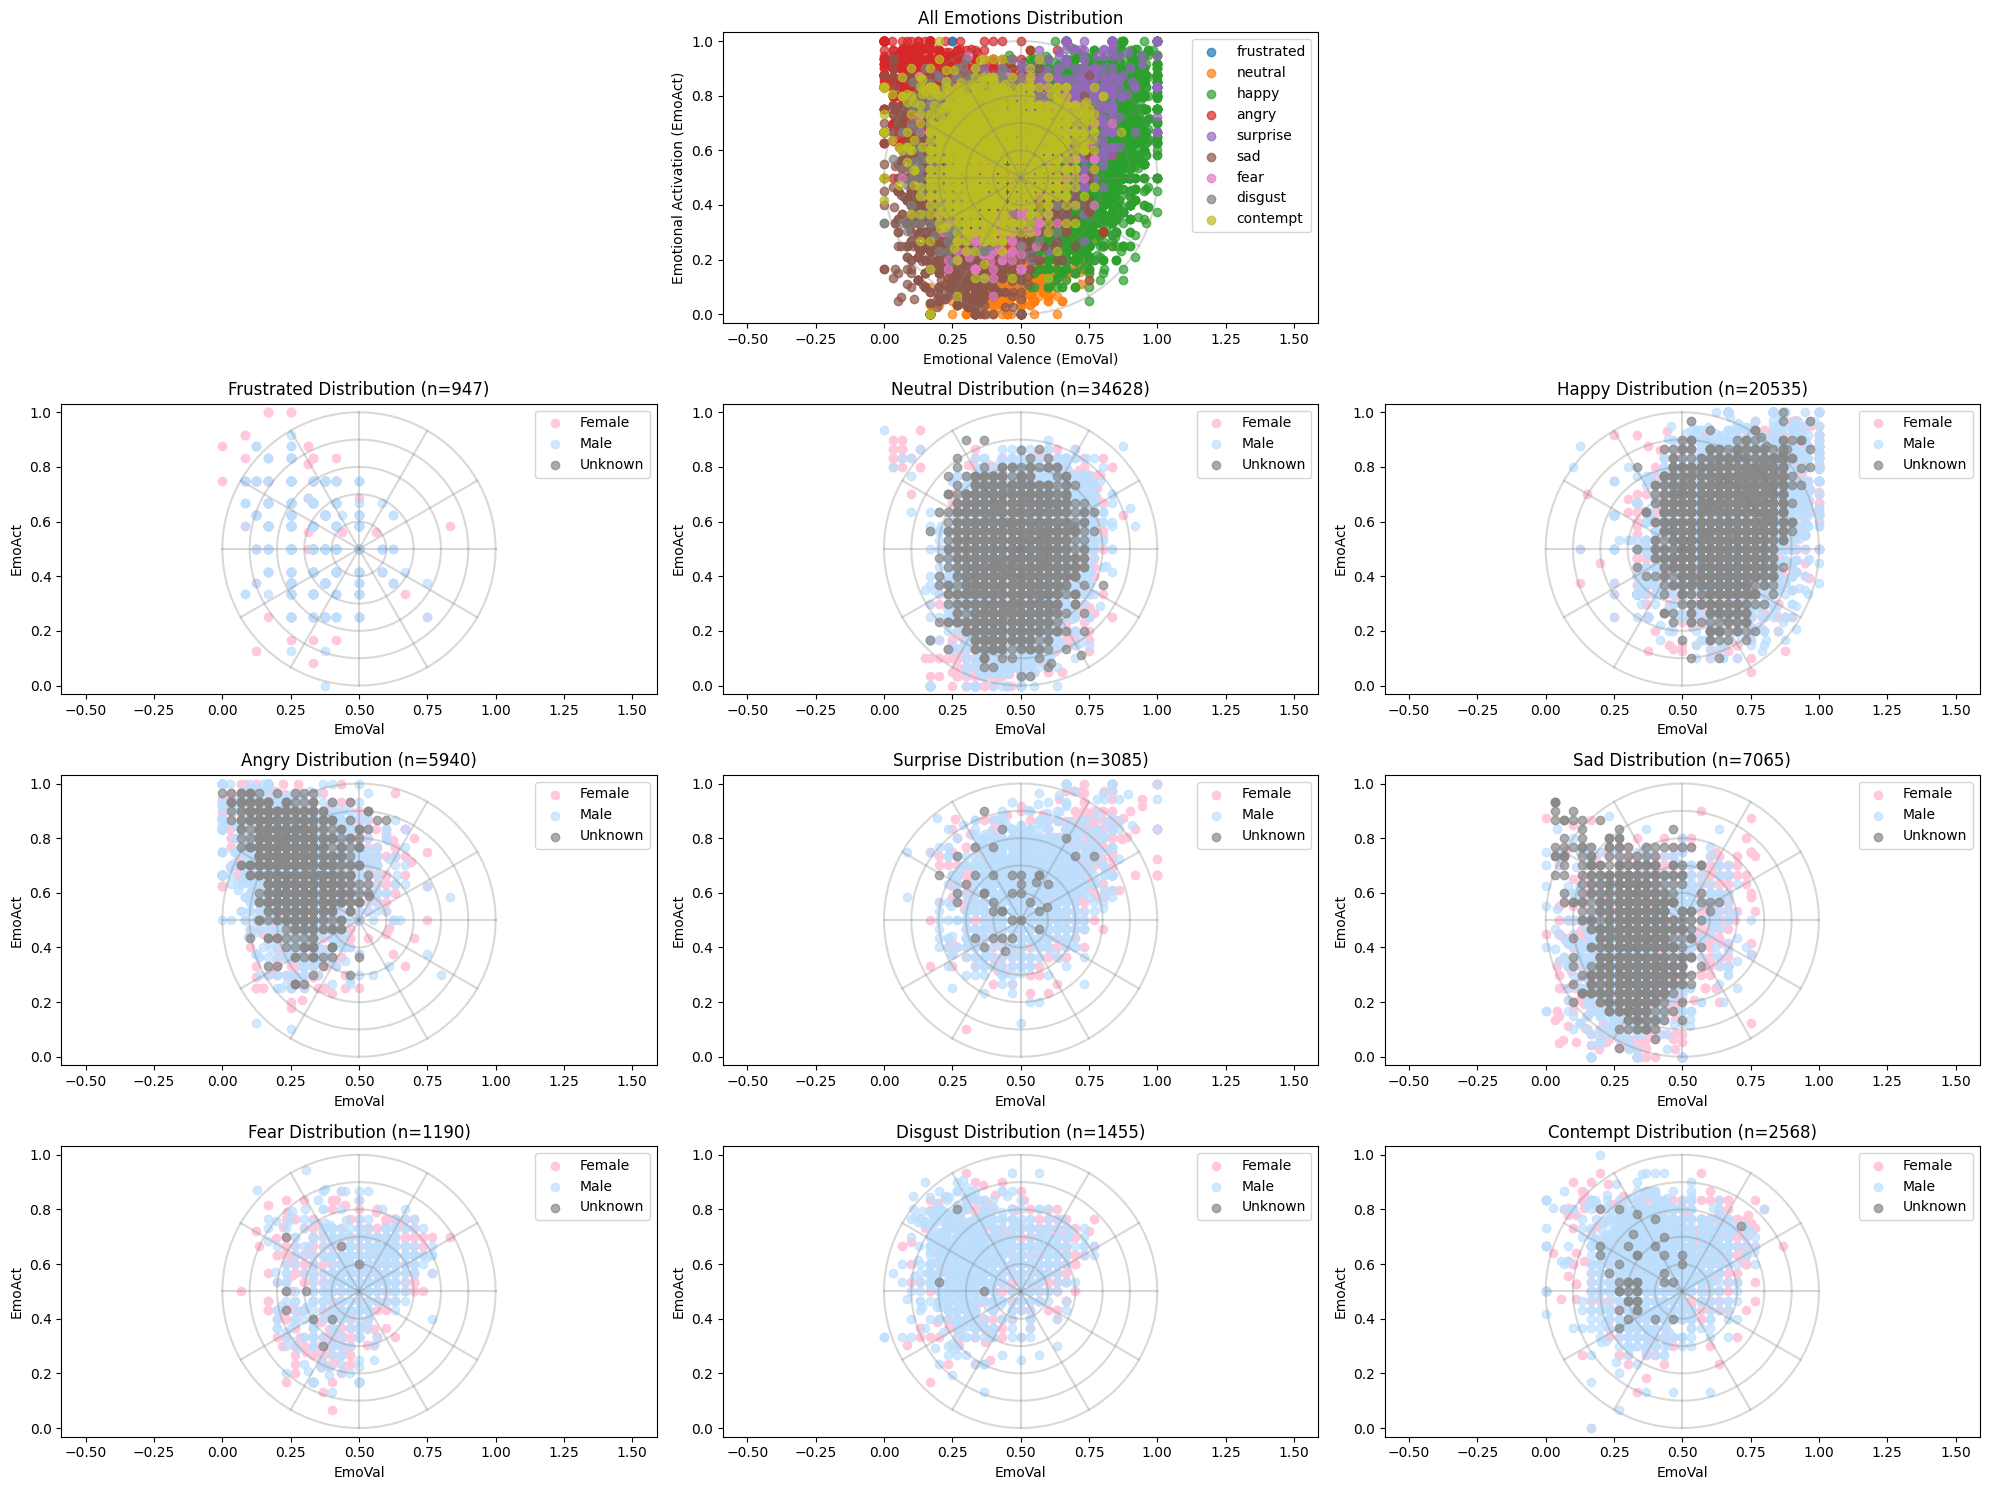

In [112]:
get_full_plot(total_emotion,combined_df)

### Run DBSCAN

In [115]:
for emo in total_emotion:
    emo_subset = combined_df[combined_df['dominant_emotion'] == emo]
    unknown_count = len(emo_subset[emo_subset['Gender'] == 'Unknown'])
    print(f'Unknown portion in {emo}: {unknown_count / len(emo_subset) * 100:.1f}%')

Unknown portion in frustrated: 0.0%
Unknown portion in neutral: 15.6%
Unknown portion in happy: 17.5%
Unknown portion in angry: 26.7%
Unknown portion in surprise: 1.3%
Unknown portion in sad: 24.4%
Unknown portion in fear: 0.8%
Unknown portion in disgust: 0.2%
Unknown portion in contempt: 1.6%


In [ ]:
gender_groups = ['Female','Male','Unknown']
# Create a new dataframe with selected columns from each corpus
columns_to_keep = ['FileName', 'dominant_emotion', 'EmoAct', 'EmoVal', 'Gender','Corpus']
eps = 0.045

# Initialize an empty dataframe to store our new training set
new_train_set = pd.DataFrame(columns=columns_to_keep)

for emo in total_emotion:
    emo_df = combined_df[combined_df['dominant_emotion'] == emo]
    for gender in gender_groups:
        gender_df = emo_df[emo_df['Gender'] == gender]
        if len(gender_df) > 0:
            cluster_set, cluster = apply_dbscan_clustering(gender_df, eps=eps)
            
            if cluster.max() == -1:  # If there are valid clusters (not just noise)
                cluster_samples = cluster_set[columns_to_keep].copy()
                new_train_set = pd.concat([new_train_set, cluster_samples], ignore_index=True)
            else:
                cluster_set = cluster_set[cluster_set['cluster'] == 0]
                cluster_samples = cluster_set[columns_to_keep].copy()
                new_train_set = pd.concat([new_train_set, cluster_samples], ignore_index=True)

new_train_set.to_csv(f'trainset_{eps}')

In [ ]:
for emo in total_emotion:
    original_set = combined_df[combined_df['dominant_emotion'] == emo]
    new_set = new_train_set[new_train_set['dominant_emotion'] == emo]
    print('='*10 + emo.center(12) + '='*10)
    for gender in gender_groups:
        original_part_size = len(original_set[original_set['Gender'] == gender])
        new_part_size = len(new_set[new_set['Gender'] == gender])
        print(f'Clustering drop rate of {gender}: { (1 - new_part_size / original_part_size) * 100:.1f}%')
    print(f'Overall clustering drop rate: { (1 - len(new_set) / len(original_set)) * 100:.1f}%')
print('='*32)
print(f'Total clustering drop rate: { (1 - len(new_train_set) / len(combined_df)) * 100:.1f}%')